In [1]:
from agent import Agent
from monitor import interact
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import random
from collections import deque
import sys
import math

In [2]:
def plot_performance(num_episodes, avg_score, plot_every):
    plt.plot(np.linspace(0, num_episodes, len(avg_score), endpoint=False), np.asarray(avg_score))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next {} Episodes)'.format(plot_every))
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_score))
    return

In [3]:
class Agent:

    def __init__(self, num_episodes, nA=6, alpha=0.1, gamma=1.0, eps=1.0):
        """ Initialize agent.

        Params
        ======
        - nA: number of actions available to the agent
        """
        self.nA = nA
        self.alpha = alpha
        self.gamma = gamma
        self.i_episode = 1
        self.num_episodes = num_episodes
        self.eps = eps
        self.Q = defaultdict(lambda: np.zeros(self.nA))

    def select_action(self, state):
        """ Given the state, select an action.

        Params
        ======
        - state: the current state of the environment

        Returns
        =======
        - action: an integer, compatible with the task's action space
        """
        return self.epsilon_greedy(state)

    def epsilon_greedy(self, state):
        if random.random() > self.eps:
            q_s = self.Q[state]
            action = np.argmax(q_s)
        else:
            action = random.randint(0, self.nA - 1)
        return action

    def update_hyper_parameter(self):
        self.i_episode += 1
        if self.i_episode <= 0.5 * self.num_episodes:
            self.eps -= (1.0/self.i_episode)
            self.gamma = 0.9
            self.alpha = 0.05
        elif self.i_episode <= 0.8*self.num_episodes:
            self.eps = 0.5/(self.i_episode-self.num_episodes*0.5)
            self.gamma = 0.8
            self.alpha = 0.01
        else:
            self.eps = 0.0
            self.gamma = 0.9
            self.alpha = 0.2
        return

    def step(self, state, action, reward, next_state, done):
        """ Update the agent's knowledge, using the most recently sampled tuple.

        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        self.Q[state][action] = self.update_q_learning(state, action, reward, next_state)
        if done:
            self.update_hyper_parameter()

        return

    def update_q_learning(self, state, action, reward, next_state=None):
        q_s_a = self.Q[state][action]
        next_q_s_max = np.max(self.Q[next_state]) if next_state is not None else 0
        return q_s_a + self.alpha * (reward + self.gamma * next_q_s_max - q_s_a)



In [4]:
def interact(env, agent, num_episodes=20000, window=100):
    """ Monitor agent's performance.
    
    Params
    ======
    - env: instance of OpenAI Gym's Taxi-v1 environment
    - agent: instance of class Agent (see Agent.py for details)
    - num_episodes: number of episodes of agent-environment interaction
    - window: number of episodes to consider when calculating average rewards

    Returns
    =======
    - avg_rewards: deque containing average rewards
    - best_avg_reward: largest value in the avg_rewards deque
    """
    # initialize average rewards
    avg_rewards = deque(maxlen=num_episodes)
    # initialize best average reward
    best_avg_reward = -math.inf
    # initialize monitor for most recent rewards
    samp_rewards = deque(maxlen=window)
    # for each episode
    for i_episode in range(1, num_episodes+1):
        # begin the episode
        state = env.reset()
        # initialize the sampled reward
        samp_reward = 0

        while True:
            # agent selects an action
            action = agent.select_action(state)
            # agent performs the selected action
            next_state, reward, done, _ = env.step(action)
            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done)
            # update the sampled reward
            samp_reward += reward
            # update the state (s <- s') to next time step
            state = next_state
            if done:
                # save final sampled reward
                samp_rewards.append(samp_reward)
                break
        if i_episode >= 100:
            # get average reward from last 100 episodes
            avg_reward = np.mean(samp_rewards)
            # append to deque
            avg_rewards.append(avg_reward)
            # update best average reward
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
        # monitor progress
        print("\rEpisode {}/{} || Best average reward {}".format(i_episode, num_episodes, best_avg_reward), end="")
        sys.stdout.flush()
        # check if task is solved (according to OpenAI Gym)
        if best_avg_reward >= 9.7:
            print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
            break
        if i_episode == num_episodes: print('\n')
    return avg_rewards, best_avg_reward

In [5]:
def main():
    env = gym.make('Taxi-v2')
    num_episodes = 20000
    window = 100
    agent = Agent(num_episodes)
    avg_rewards, best_avg_reward = interact(env, agent, num_episodes=num_episodes, window=window)

    # print('avg_rewards: {}, best_avg_reward: {}'.format(avg_rewards, best_avg_reward))
    plot_performance(num_episodes=num_episodes, avg_score=avg_rewards, plot_every=window)
    return

Episode 20000/20000 || Best average reward 9.392



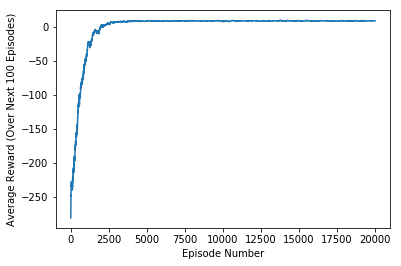

Best Average Reward over 100 Episodes:  9.39


In [6]:
main()